<a href="https://colab.research.google.com/github/Rtarachan02/ResearchWork/blob/main/latest_drought_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MULTIVARIATE TCNN MODEL FOR AGRICULTURAL DROUGHT PREDICTION**

# **Importing Libraries**

In [13]:
#importing the necessary libraries
import pandas as pd
import numpy as np
!pip install tensorflow
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import drive
import os

In [14]:
#installing h5py
%pip install h5py
import h5py

In [15]:
#import libraries for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,ConvLSTM2D,Conv1D, MaxPooling2D,MaxPooling1D, Flatten, Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,AdamW
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import time

In [16]:
#mounting the drive an dfetching data from the location
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Loading and Visulization**

In [ ]:
#Accessing TMAX data from drive
tmax_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/tmax_india_1951-2020.csv'
print("Printing TMAX Data")
tmax = pd.read_csv(tmax_path)
tmax.head()

In [ ]:
#Aceesing TMIN data from drive
tmin_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/tmin_india_1951-2020.csv'
print("Printing TMIN Data")
tmin = pd.read_csv(tmin_path)
tmin.head()

In [ ]:
#finding the TAVG data from TMIN and TMAX datasets
tavg=(tmax+tmin)/2
tavg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/tavg_india_1951-2020.csv'
tavg.to_csv(tavg_path, index=False)
tavg.head()

In [ ]:
tmin.shape

In [ ]:
#loading the soil moistures data
sm_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/sm_daily_0_28_new.csv'
print("Printing Soil Moistures Data")
sm = pd.read_csv(sm_path)
sm.head()

In [ ]:
sm.shape

In [ ]:
#finding the corresponding max sm data and min sm datas and storing to the drive
smmin=sm.min()
smmax=sm.max()
smci=(sm-smmin)/(smmax-smmin)
smci_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/smci_india_1959-2020.csv'
smci.to_csv(smci_path,index=False)
smci.head()

In [ ]:
#loading vapour pressure deficit data
vpd_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/vpd.csv'
print("Printing Vapour pressure deficit Data")
vpd = pd.read_csv(vpd_path)
vpd.head()


In [ ]:
vpd.shape

In [ ]:
#loading potential Evapotranspiration data
pet_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/PET_daily_1959_2020.csv'
print("Printing potential evapotransiration Data")
pet = pd.read_csv(pet_path)
pet.head()

In [ ]:
pet.shape

In [ ]:
#loading precipitation data
pr_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/pr_1951_2020.csv'
print("Printing precipitation Data")
pr = pd.read_csv(pr_path)
pr.tail()

In [ ]:
pr.shape

# **Data Preprocessing**

## **1.Removing Data Ambiguity in AVG Temperature**

In [ ]:
#Removing data from avg temperature data
tavg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/tavg_india_1951-2020.csv'
tavg = pd.read_csv(tavg_path)
tavg.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V4633,V4634,V4635,V4636,V4637,V4638,V4639,V4640,V4641,V4642
0,17.2895,17.3620,17.950,16.7865,18.140,17.930,17.420,18.135,17.930,19.335,...,5.245,19.075,11.645,10.770,18.485,4.920,-2.3180,6.1815,2.7040,4.460
1,19.2675,19.3770,18.260,18.7545,18.460,18.250,17.730,18.440,18.245,19.725,...,4.855,18.655,11.190,10.450,18.095,4.515,-2.6795,6.3645,3.0075,4.070
2,18.6555,19.0715,19.105,18.6625,19.410,19.185,18.630,19.265,18.960,21.005,...,4.670,18.435,10.975,10.295,17.920,4.305,-2.4235,5.7795,2.7735,3.860
3,18.7510,18.9355,18.835,18.4490,19.145,18.920,18.360,19.000,18.715,20.545,...,4.380,18.170,10.725,9.975,17.630,4.035,-0.8430,6.6240,3.5965,3.585
4,19.2210,19.3000,17.910,18.9530,18.095,17.880,17.375,18.100,17.955,19.195,...,4.215,18.005,10.565,9.795,17.460,3.870,-0.9155,6.5675,3.5380,3.415


In [ ]:
#finding last Ndata
N=22646
tavg_tail=tavg.tail(N)
tavg_tail.shape

(22646, 4641)

In [ ]:

# Generate a date range from 1959-01-01 to 2020-12-31
date_range = pd.date_range(start='1959-01-01', end='2020-12-31', freq='D')
dates_df = pd.DataFrame(date_range, columns=['Date'])
print(len(dates_df) == len(tavg_tail))
data_with_dates = pd.concat([dates_df,tavg_tail.reset_index(drop=True)], axis=1)
# Transpose the data so that dates become columns
transposed_data = data_with_dates.set_index('Date').transpose()
# Remove columns where the date is February 29th
filtered_transposed_data = transposed_data.drop(
    columns=[col for col in transposed_data.columns if (col.month == 2) & (col.day == 29)]
)
print(transposed_data.shape)
# Reset the index to 0 to N-1
filtered_transposed_data.reset_index(drop=True, inplace=True)
print(filtered_transposed_data.shape)
filtered_transposed_data.tail()



True
(4641, 22646)
(4641, 22630)


Date,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
4636,1.4300,1.2200,1.600,0.8300,1.0450,1.9650,2.520,0.7050,0.565,1.3800,...,16.5535,16.8815,16.8910,16.6260,16.7165,16.4330,16.4755,16.3260,16.4760,16.5735
4637,-2.4395,-0.7990,-0.645,1.3495,0.0030,0.3735,0.579,-2.4315,-3.253,-3.1975,...,16.6010,16.9285,16.9355,16.6695,16.7565,16.4820,16.5240,16.3675,16.5155,16.6160
4638,4.8290,6.7115,6.849,6.9805,7.0390,6.9595,6.582,4.6965,3.789,3.5390,...,16.4215,16.7365,16.7625,16.4855,16.5800,16.2870,16.3405,16.2130,16.3570,16.4505
4639,1.5540,3.3805,3.952,4.6525,3.6945,4.3845,3.825,1.6920,0.472,0.3915,...,16.4635,16.7825,16.8010,16.5235,16.6190,16.3255,16.3790,16.2495,16.3910,16.4885
4640,1.0800,0.8750,1.250,0.4900,0.6950,1.6150,2.170,0.3700,0.225,1.0300,...,16.4880,16.8120,16.8315,16.5485,16.6420,16.3525,16.4085,16.2755,16.4155,16.5120


In [ ]:
#saving the data to Xtrain Paths
xtrn_tavg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/tavg.csv'
filtered_transposed_data.to_csv(xtrn_tavg_path, index=False)

## **2.Removing Data Ambiguity in Potential Evapotransiration**

In [ ]:
#loading potential Evapotranspiration data
pet_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/PET_daily_1959_2020.csv'
print("Printing potential evapotransiration Data")
pet = pd.read_csv(pet_path)
pet.head()

Printing potential evapotransiration Data


,X1959.01.02,X1959.01.02.1,X1959.01.03,X1959.01.04,X1959.01.05,X1959.01.06,X1959.01.07,X1959.01.08,X1959.01.09,X1959.01.10,...,X2020.12.22,X2020.12.23,X2020.12.24,X2020.12.25,X2020.12.26,X2020.12.27,X2020.12.28,X2020.12.29,X2020.12.30,X2020.12.31
0,-0.003465,-0.003537,-0.002934,-0.004181,-0.003651,-0.003886,-0.003380,-0.002911,-0.003030,-0.004178,...,-0.00394,-0.00411,-0.00424,-0.00416,-0.00399,-0.00412,-0.00337,-0.00428,-0.00409,-0.00405
1,-0.002502,-0.002540,-0.002232,-0.002927,-0.002670,-0.003052,-0.002629,-0.002300,-0.002009,-0.003141,...,-0.00295,-0.00301,-0.00310,-0.00300,-0.00292,-0.00290,-0.00253,-0.00324,-0.00321,-0.00311
2,-0.003159,-0.003205,-0.002810,-0.003873,-0.003415,-0.003674,-0.003187,-0.002782,-0.002698,-0.003874,...,-0.00366,-0.00378,-0.00388,-0.00378,-0.00366,-0.00368,-0.00320,-0.00402,-0.00393,-0.00384
3,-0.003679,-0.003711,-0.003187,-0.004554,-0.003909,-0.004118,-0.003568,-0.003093,-0.003250,-0.004419,...,-0.00419,-0.00437,-0.00447,-0.00439,-0.00422,-0.00429,-0.00369,-0.00457,-0.00441,-0.00435
4,-0.002551,-0.002557,-0.002288,-0.002812,-0.002646,-0.003153,-0.002728,-0.002426,-0.002007,-0.003158,...,-0.00298,-0.00306,-0.00312,-0.00298,-0.00294,-0.00294,-0.00267,-0.00325,-0.00321,-0.00309


In [ ]:
# Generate a date range from 1959-01-01 to 2020-12-31
date_range = pd.date_range(start='1959-01-01', end='2020-12-31', freq='D')
pet.columns= date_range
pet.head()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
0,-0.003465,-0.003537,-0.002934,-0.004181,-0.003651,-0.003886,-0.003380,-0.002911,-0.003030,-0.004178,...,-0.00394,-0.00411,-0.00424,-0.00416,-0.00399,-0.00412,-0.00337,-0.00428,-0.00409,-0.00405
1,-0.002502,-0.002540,-0.002232,-0.002927,-0.002670,-0.003052,-0.002629,-0.002300,-0.002009,-0.003141,...,-0.00295,-0.00301,-0.00310,-0.00300,-0.00292,-0.00290,-0.00253,-0.00324,-0.00321,-0.00311
2,-0.003159,-0.003205,-0.002810,-0.003873,-0.003415,-0.003674,-0.003187,-0.002782,-0.002698,-0.003874,...,-0.00366,-0.00378,-0.00388,-0.00378,-0.00366,-0.00368,-0.00320,-0.00402,-0.00393,-0.00384
3,-0.003679,-0.003711,-0.003187,-0.004554,-0.003909,-0.004118,-0.003568,-0.003093,-0.003250,-0.004419,...,-0.00419,-0.00437,-0.00447,-0.00439,-0.00422,-0.00429,-0.00369,-0.00457,-0.00441,-0.00435
4,-0.002551,-0.002557,-0.002288,-0.002812,-0.002646,-0.003153,-0.002728,-0.002426,-0.002007,-0.003158,...,-0.00298,-0.00306,-0.00312,-0.00298,-0.00294,-0.00294,-0.00267,-0.00325,-0.00321,-0.00309


In [ ]:
# Remove columns where the date is February 29th
filtered_pet = pet.drop(
    columns=[col for col in pet.columns if (col.month == 2) & (col.day == 29)]
)
# Reset the index to 0 to N-1
filtered_pet.reset_index(drop=True, inplace=True)
filtered_pet.tail()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
4636,-0.001151,-0.001158,-0.001246,-0.001446,-0.001117,-0.001114,-0.001078,-0.000968,-0.001315,-0.001433,...,-0.00162,-0.00143,-0.00175,-0.00161,-0.00180,-0.00159,-0.00162,-0.00179,-0.00189,-0.00180
4637,-0.000791,-0.000787,-0.000908,-0.001043,-0.000701,-0.000753,-0.000678,-0.000628,-0.000827,-0.000805,...,-0.00109,-0.00091,-0.00121,-0.00102,-0.00122,-0.00105,-0.00108,-0.00128,-0.00133,-0.00126
4638,-0.001268,-0.001523,-0.001451,-0.002027,-0.001997,-0.001869,-0.001310,-0.001273,-0.001593,-0.001342,...,-0.00162,-0.00191,-0.00260,-0.00262,-0.00212,-0.00264,-0.00273,-0.00277,-0.00289,-0.00289
4639,-0.001206,-0.001255,-0.001078,-0.001426,-0.001350,-0.001284,-0.001371,-0.001097,-0.001362,-0.001478,...,-0.00171,-0.00164,-0.00184,-0.00171,-0.00190,-0.00170,-0.00179,-0.00190,-0.00202,-0.00198
4640,-0.001146,-0.001145,-0.001134,-0.001366,-0.001088,-0.001148,-0.001210,-0.001038,-0.001280,-0.001360,...,-0.00144,-0.00129,-0.00155,-0.00150,-0.00164,-0.00136,-0.00150,-0.00163,-0.00176,-0.00167


In [ ]:
#saving the data to Xtrain Paths
xtrn_pet_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/pet.csv'
filtered_pet.to_csv(xtrn_pet_path, index=False)

## **3.Removing Data Ambiguity in Precipitation**

In [ ]:
#loading precipitation data
pr_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/pr_1951_2020.csv'
print("Printing precipitation Data")
pr = pd.read_csv(pr_path)
pr.tail()

Printing precipitation Data


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.4514,0.4515,0.4516,0.4517,0.4518,0.4519,0.4520,0.4521,0.4522,0.4523
25562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
25563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
25564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
25565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
25566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


In [ ]:
#replacing nan data with 0
pr1=pr.fillna(0)
pr1.tail()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.4514,0.4515,0.4516,0.4517,0.4518,0.4519,0.4520,0.4521,0.4522,0.4523
25562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#considering last Ndata
N=22646
pr1_tail=pr1.tail(N)
pr1_tail.shape

(22646, 4641)

In [ ]:
# Generate a date range from 1959-01-01 to 2020-12-31
date_range = pd.date_range(start='1959-01-01', end='2020-12-31', freq='D')
# Transpose the data so that dates become columns
pr1_tail_transpose = pr1_tail.transpose()
pr1_tail_transpose.columns= date_range
pr1_tail_transpose.head()

# Remove columns where the date is February 29th
filtered_data = pr1_tail_transpose.drop(
    columns=[col for col in pr1_tail_transpose.columns if (col.month == 2) & (col.day == 29)]
)
# Reset the index to 0 to N-1
filtered_data.reset_index(drop=True, inplace=True)
filtered_data.tail()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
4636,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4637,0.0,0.0,0.0,0.0,0.0,0.0,1.4941,1.1503,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4638,0.0,0.0,0.0,0.0,0.0,0.0,2.6621,2.3023,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4639,0.0,0.0,0.0,0.0,0.0,0.0,2.2428,1.8840,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4640,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
filtered_data.shape

(4641, 22630)

In [ ]:
#saving the data into the traing path
xtrn_pr_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/pr.csv'
filtered_data.to_csv(xtrn_pr_path, index=False)

## **4.Removing Data Ambiguity in Vapour Pressure Deficit**

In [ ]:
#loading vapour pressure deficit data
vpd_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/vpd.csv'
print("Printing Vapour pressure deficit Data")
vpd = pd.read_csv(vpd_path)
vpd.head()


Printing Vapour pressure deficit Data


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V4633,V4634,V4635,V4636,V4637,V4638,V4639,V4640,V4641,V4642
0,11.036795,9.761987,12.793126,10.604930,12.340803,13.303174,12.730988,13.122038,12.931216,10.966467,...,-1.319362,10.262282,6.588801,2.212739,10.983205,0.690278,0.598689,-1.740765,0.836929,1.848625
1,10.379849,9.238094,13.358936,10.647679,12.883459,13.759022,13.147605,13.555646,13.456316,13.404671,...,-1.518358,9.728864,6.136601,1.885495,10.628847,0.348729,0.947348,-0.380041,1.546799,1.450881
2,5.536126,5.083122,8.597101,5.951840,8.545822,9.309893,8.716910,9.051505,8.924570,10.859969,...,-1.388296,10.123020,6.371555,2.490341,11.021571,0.461611,0.960393,0.134066,1.923795,1.713247
3,9.897029,8.179772,14.707136,9.856919,12.861755,14.271734,14.526114,15.263661,14.747090,11.655803,...,-1.466855,9.337013,5.866294,2.321479,10.258686,0.067001,2.056385,0.558289,2.381392,1.267284
4,10.606793,11.027852,12.336978,10.299688,12.903807,13.642075,12.397358,11.659383,11.249671,11.226427,...,-1.974861,9.034124,5.085437,1.746176,9.998694,-0.229089,0.397123,0.076244,1.346954,0.973126


In [ ]:
vpd.shape

(22630, 4641)

In [ ]:
# Generate a date range from 1959-01-01 to 2020-12-31
date_range = pd.date_range(start='1959-01-01', end='2020-12-31', freq='D')
# Filter out February 29 dates
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]
vpd_transpose = vpd.transpose()
vpd_transpose.columns= filtered_date_range
vpd_transpose.head()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
V2,11.036795,10.379849,5.536126,9.897029,10.606793,10.803741,10.465248,8.873411,8.817259,10.658252,...,15.513969,14.448700,15.401178,15.742798,15.621962,15.657718,11.406203,12.526492,12.196743,12.805579
V3,9.761987,9.238094,5.083122,8.179772,11.027852,11.317775,10.353690,8.945136,7.945653,10.393749,...,15.136300,14.229216,14.820812,14.668331,14.725763,14.023510,11.528128,12.545372,12.635602,12.889467
V4,12.793126,13.358936,8.597101,14.707136,12.336978,11.636998,10.529983,7.437852,7.261743,11.124875,...,15.671203,14.701759,15.388586,15.364911,15.474450,14.929996,11.781843,12.761603,12.695396,13.129119
V5,10.604930,10.647679,5.951840,9.856919,10.299688,10.334665,9.134706,8.771308,8.869954,10.091917,...,15.470058,14.457088,15.341166,15.444754,15.413342,14.925687,11.494463,12.421190,12.205173,12.776358
V6,12.340803,12.883459,8.545822,12.861755,12.903807,12.861505,11.929091,8.516230,5.921473,11.557994,...,15.587918,14.788808,15.177446,14.447521,14.504745,14.216200,12.484881,13.179017,13.265432,13.229717


In [ ]:
vpd_transpose.shape

(4641, 22630)

In [ ]:
#saving data into the training path
xtrn_vpd_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/vpd.csv'
vpd_transpose.to_csv(xtrn_vpd_path, index=False)

## **5.Removing Data Ambiguity in Soil Moisture Data**

In [27]:
#loading the soil moistures data
sm_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/sm_daily_0_28_new.csv'
print("Printing Soil Moistures Data")
sm = pd.read_csv(sm_path)
sm.head()

Printing Soil Moistures Data


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Raw Data/sm_daily_0_28_new.csv'

In [ ]:
# Generate a date range from 1959-01-01 to 2020-12-31
date_range = pd.date_range(start='1959-01-01', end='2020-12-31', freq='D')
sm.columns= date_range
# Remove columns where the date is February 29th
filtered_sm_data = sm.drop(
    columns=[col for col in sm.columns if (col.month == 2) & (col.day == 29)]
)
# Reset the index to 0 to N-1
filtered_sm_data.reset_index(drop=True, inplace=True)
filtered_sm_data.tail()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
4636,0.677378,0.681944,0.683539,0.684980,0.688014,0.682611,0.678334,0.672633,0.664701,0.652878,...,0.615699,0.609108,0.602392,0.597248,0.592689,0.591209,0.587054,0.582546,0.579438,0.576701
4637,0.663835,0.667445,0.669575,0.671566,0.676354,0.674931,0.672873,0.669269,0.664401,0.656437,...,0.634044,0.631432,0.628969,0.626355,0.626815,0.626669,0.624975,0.623238,0.622542,0.622656
4638,0.644630,0.643845,0.644079,0.638434,0.631648,0.622678,0.625446,0.639080,0.636178,0.627575,...,0.588531,0.586445,0.583677,0.579199,0.577562,0.575821,0.572102,0.570117,0.567844,0.563995
4639,0.709717,0.707891,0.708201,0.705687,0.706693,0.706740,0.702790,0.699128,0.692794,0.688202,...,0.712261,0.704234,0.697899,0.697066,0.692983,0.688623,0.683089,0.675810,0.669665,0.665308
4640,0.641261,0.643657,0.646318,0.650635,0.655043,0.653565,0.647770,0.642559,0.638370,0.632401,...,0.655186,0.649240,0.644488,0.639072,0.635557,0.635990,0.634096,0.630483,0.628407,0.626473


In [ ]:
#saving data into the training path
xtrn_sm_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/sm.csv'
filtered_sm_data.to_csv(xtrn_sm_path, index=False)

## **6.Calculating SMCI from Soil Moisture Data**

In [ ]:
smci = (filtered_sm_data - filtered_sm_data.min()) / (filtered_sm_data.max() - filtered_sm_data.min())
smci.tail()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
4636,0.713229,0.723348,0.721284,0.670155,0.669888,0.683392,0.690786,0.696229,0.695754,0.690958,...,0.627265,0.598834,0.603826,0.608055,0.614633,0.630041,0.638121,0.616351,0.612291,0.597651
4637,0.697152,0.706078,0.704825,0.655539,0.657270,0.674835,0.684600,0.692363,0.695405,0.695144,...,0.648456,0.623718,0.634067,0.641726,0.654873,0.672990,0.684965,0.665261,0.663987,0.651636
4638,0.674351,0.677971,0.674774,0.619438,0.608889,0.616610,0.630879,0.657668,0.662598,0.661198,...,0.595882,0.573572,0.582530,0.587177,0.596796,0.611403,0.619651,0.601412,0.598387,0.582725
4639,0.751623,0.754251,0.750352,0.692717,0.690103,0.710279,0.718488,0.726678,0.728410,0.732504,...,0.738807,0.704868,0.712501,0.723522,0.732896,0.748030,0.756752,0.728449,0.720502,0.701742
4640,0.670351,0.677747,0.677412,0.632732,0.634208,0.651027,0.656165,0.661667,0.665146,0.666873,...,0.672878,0.643568,0.651726,0.656437,0.665182,0.684280,0.696232,0.673969,0.671021,0.656120


In [ ]:
#saving data into the training path
xtrn_smci_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/smci.csv'
smci.to_csv(xtrn_smci_path, index=False)

# **Model Features Selection**

## **Normalizing Input Features**

In [ ]:
#reading file paths for INPUT FEATURES
xtrn_tavg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/tavg.csv'
xtrn_pr_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/pr.csv'
xtrn_pet_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/pet.csv'
xtrn_vpd_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/vpd.csv'

#reading into the dataframes
df_tavg=pd.read_csv(xtrn_tavg_path)
df_pr=pd.read_csv(xtrn_pr_path)
df_pet=pd.read_csv(xtrn_pet_path)
df_vpd=pd.read_csv(xtrn_vpd_path)



In [ ]:
#Normalizing the features
dfn_tavg=(df_tavg-df_tavg.min())/(df_tavg.max()-df_tavg.min())
dfn_pr=(df_pr-df_pr.min())/(df_pr.max()-df_pr.min())
dfn_pet=(df_pet-df_pet.min())/(df_pet.max()-df_pet.min())
dfn_vpd=(df_vpd-df_vpd.min())/(df_vpd.max()-df_vpd.min())

In [ ]:
#Handling NaN cases
dfn_tavg=dfn_tavg.fillna(0)
dfn_pr=dfn_pr.fillna(0)
dfn_pet=dfn_pet.fillna(0)
dfn_vpd=dfn_vpd.fillna(0)

In [ ]:
dfn_pet.head()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
0,0.473797,0.451337,0.565108,0.395545,0.473646,0.440461,0.509471,0.562099,0.557799,0.377479,...,0.382979,0.310065,0.332827,0.393855,0.416783,0.415068,0.481536,0.366619,0.403338,0.293729
1,0.613923,0.599995,0.664134,0.570834,0.609622,0.556907,0.615327,0.651339,0.703985,0.529659,...,0.533435,0.488636,0.506079,0.555866,0.566434,0.582192,0.605613,0.514979,0.525730,0.448845
2,0.518356,0.500860,0.582559,0.438641,0.506379,0.470088,0.536570,0.580988,0.605322,0.422019,...,0.425532,0.363636,0.387538,0.446927,0.462937,0.475342,0.506647,0.403709,0.425591,0.328383
3,0.442598,0.425367,0.529372,0.343388,0.437885,0.408104,0.482884,0.535538,0.526272,0.342098,...,0.344985,0.267857,0.297872,0.361732,0.384615,0.391781,0.434269,0.325250,0.358832,0.244224
4,0.606873,0.597540,0.656238,0.587034,0.612997,0.542792,0.601326,0.632835,0.704238,0.527120,...,0.528875,0.480519,0.503040,0.558659,0.563636,0.576712,0.584934,0.513552,0.525730,0.452145


## **Input Features Conversion to HDF5 Data**

In [ ]:
# Write DataFrames to HDF5 file
x_train_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Training Set/X_train.h5'

with h5py.File(x_train_path, 'w') as f:
    # Convert DataFrames to NumPy arrays
    tavg_array = dfn_tavg.to_numpy()
    pr_array = dfn_pr.to_numpy()
    pet_array = dfn_pet.to_numpy()
    vpd_array = dfn_vpd.to_numpy()

    # Create datasets in HDF5 file
    f.create_dataset('tavg', data=tavg_array)
    f.create_dataset('pr', data=pr_array)
    f.create_dataset('pet', data=pet_array)
    f.create_dataset('vpd', data=vpd_array)

print("DataFrames converted and saved to X_TRAIN HDF5 file in Google Drive.")

DataFrames converted and saved to X_TRAIN HDF5 file in Google Drive.


## **Output Feature Convesrion to HDF5 Data**

In [ ]:
#reading file paths for SMCI Value(Note :SMCI is already normalized)
xtrn_smci_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/smci.csv'
df_smci=pd.read_csv(xtrn_smci_path)
df_smci.head()

,1959-01-01,1959-01-02,1959-01-03,1959-01-04,1959-01-05,1959-01-06,1959-01-07,1959-01-08,1959-01-09,1959-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
0,0.141710,0.139856,0.143903,0.139047,0.137773,0.140708,0.145067,0.147577,0.149717,0.154913,...,0.129778,0.127731,0.130583,0.133140,0.139069,0.140494,0.147322,0.145711,0.148311,0.143276
1,0.121524,0.123015,0.124466,0.118905,0.118815,0.121651,0.125409,0.128772,0.130859,0.134196,...,0.124027,0.119481,0.123210,0.125278,0.130004,0.136116,0.139221,0.133343,0.133704,0.129607
2,0.146524,0.145272,0.147395,0.141945,0.141511,0.144800,0.147689,0.150315,0.152327,0.156524,...,0.138818,0.134107,0.138287,0.141538,0.147161,0.150753,0.155914,0.151600,0.153457,0.148527
3,0.186013,0.183986,0.185039,0.175718,0.177177,0.182219,0.186425,0.188701,0.190751,0.195733,...,0.165432,0.161393,0.165769,0.170746,0.177559,0.179252,0.185986,0.182487,0.185423,0.178805
4,0.163851,0.167594,0.169018,0.158671,0.159308,0.163697,0.168588,0.173711,0.177074,0.181403,...,0.167326,0.161669,0.165032,0.166854,0.172149,0.178916,0.187743,0.182820,0.181642,0.174783


In [ ]:
sum(df_smci.isna().sum())

0

In [ ]:
# Write DataFrames to HDF5 file
y_train_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Training Set/Y_train.h5'
with h5py.File(y_train_path, 'w') as f:
    # Convert DataFrames to NumPy arrays
    smci_array = df_smci.to_numpy()
    # Create datasets in HDF5 file
    f.create_dataset('smci', data=smci_array)

print("DataFrames converted and saved to Y_TRAIN HDF5 file in Google Drive.")


DataFrames converted and saved to Y_TRAIN HDF5 file in Google Drive.


 # **Models Definition and Iterative Training of Data Grids**

## **Accuracy Predictor**

In [17]:
def label_predictor(smci_data):
    # Initialize an empty array to store labels
    labels = np.empty(smci_data.shape, dtype=object)
     # Apply the classification rules
    labels[smci_data >= 0.4] = 'ND'  # No Drought
    labels[(0.3 <= smci_data) & (smci_data < 0.4)] = 'MD'  # Mild Drought
    labels[(0.2 <= smci_data) & (smci_data < 0.3)] = 'MOD'  # Moderate Drought
    labels[(0.1 <= smci_data) & (smci_data < 0.2)] = 'SD'  # Severe Drought
    labels[smci_data < 0.1] = 'ED'  # Extreme Drought
    return labels
def accuracy_predictor(y_true, y_pred):
    # Get the true and predicted labels
    true_labels = label_predictor(y_true)
    pred_labels = label_predictor(y_pred)
    # Check if labels are empty or not
    if true_labels.size == 0 or pred_labels.size == 0:
        print("Error: Empty labels array.")
        return 0.0  # Return 0 accuracy
    # Calculate the accuracy
    accuracy = np.mean(true_labels == pred_labels) * 100
    return accuracy

In [18]:
# def label_predictor(smci_data):
#     # Round off SMCI data to two decimal points
#     smci_data = np.round(smci_data,2)
#     # Initialize an empty array to store labels
#     labels = np.empty(smci_data.shape, dtype=object)
#      # Apply the classification rules
#     labels[smci_data >= 0.4] = 'ND'  # No Drought
#     labels[(0.3 <= smci_data) & (smci_data < 0.4)] = 'MD'  # Mild Drought
#     labels[(0.2 <= smci_data) & (smci_data < 0.3)] = 'MOD'  # Moderate Drought
#     labels[(0.1 <= smci_data) & (smci_data < 0.2)] = 'SD'  # Severe Drought
#     labels[smci_data < 0.1] = 'ED'  # Extreme Drought
#     return labels
# def accuracy_predictor(y_true, y_pred):
#     # Get the true and predicted labels
#     true_labels = label_predictor(y_true)
#     pred_labels = label_predictor(y_pred)
#     # Check if labels are empty or not
#     if true_labels.size == 0 or pred_labels.size == 0:
#         print("Error: Empty labels array.")
#         return 0.0  # Return 0 accuracy
#     # Calculate the accuracy
#     accuracy = np.mean(true_labels == pred_labels) * 100
#     return accuracy

In [19]:
# def label_predictor(smci_data):
#     # Initialize an empty array to store labels
#     labels = np.empty(smci_data.shape, dtype=object)
#      # Apply the classification rules
#     labels[smci_data >= 0.8] = 'ND'  # No Drought
#     labels[(0.6 <= smci_data) & (smci_data < 0.8)] = 'MD'  # Mild Drought
#     labels[(0.4 <= smci_data) & (smci_data < 0.6)] = 'MOD'  # Moderate Drought
#     labels[(0.2 <= smci_data) & (smci_data < 0.4)] = 'SD'  # Severe Drought
#     labels[smci_data < 0.2] = 'ED'  # Extreme Drought
#     return labels
# def accuracy_predictor(y_true, y_pred):
#     # Get the true and predicted labels
#     true_labels = label_predictor(y_true)
#     pred_labels = label_predictor(y_pred)
#     # Check if labels are empty or not
#     if true_labels.size == 0 or pred_labels.size == 0:
#         print("Error: Empty labels array.")
#         return 0.0  # Return 0 accuracy
#     # Reshape labels to match each other
#     # true_labels = true_labels.reshape(-1)  # Flatten along time steps
#     # pred_labels = pred_labels.reshape(-1)  # Flatten along time steps
#     # Calculate the accuracy
#     accuracy = np.mean(true_labels == pred_labels) * 100
#     return accuracy

In [20]:
# def accuracy_predictor(y_true, y_pred):
#     threshold = 0.10  # 5%
#     epsilon = 1e-9
#     y_true_adjusted = y_true + epsilon
#     accurate_predictions = np.abs((y_true_adjusted - y_pred) / y_true_adjusted) < threshold
#     accuracy = np.mean(accurate_predictions) * 100
#     return accuracy


## **Model : Coventional CNN**

In [ ]:
#Conventional CNN model function
class CNNModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape, padding='same'),  # 'same' padding to avoid reducing dimensions too much
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),  # 'same' padding again
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            # MaxPooling2D((2, 2)),
            Flatten(),
            Dense(64, activation='linear'),
            # Dropout(0.5),
            Dense(128, activation='linear'),
            # Dropout(0.5),
            Dense(9, activation='sigmoid')  # Assuming regression task, change activation for classification
        ])
        return model

    def train(self, X_train, y_train, epochs=10, batch_size=32,learning_rate=0.001):
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Change loss for classification
        start_time = time.time()
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        end_time = time.time()
        return end_time - start_time

    def accuracy(self, X_train, Y_train):
        Y_pred = self.model.predict(X_train)
        Y_pred = Y_pred.reshape(-1)
        Y_train = Y_train.reshape(-1)
        accuracy = accuracy_predictor(Y_train, Y_pred)
        return accuracy

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred = y_pred.reshape(-1)
        y_test = y_test.reshape(-1)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r = np.corrcoef(y_test, y_pred)[0, 1]
        return mse, mae, r

## **Model : ConvLSTM**

In [21]:
class ConvLSTMModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            ConvLSTM2D(32, (1, 3), input_shape=self.input_shape, padding='same'),  # Adjusted kernel size
            Flatten(),
            Dense(64, activation='linear'),
            Dropout(0.5),
            Dense(128, activation='linear'),
            # Dropout(0.5),
            Dense(1, activation='sigmoid')   # Assuming regression task, change activation for classification
        ])
        return model

    def train(self, X_train, y_train, epochs=10, batch_size=32,learning_rate=0.005):

        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')  # Change loss for classification
        start_time = time.time()
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        end_time = time.time()
        return end_time - start_time
    def accuracy(self, X_train, Y_train):
        Y_pred = self.model.predict(X_train)
        Y_pred = Y_pred.reshape(-1)
        Y_train = Y_train.reshape(-1)
        accuracy = accuracy_predictor(Y_train, Y_pred)
        return accuracy

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred = y_pred.reshape(-1)
        y_test = y_test.reshape(-1)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
        return mse, mae, r

## **Model : T-CNN**

In [ ]:
class TCNNModel:
    def __init__(self, input_shape, time_steps):
        self.input_shape = input_shape
        self.time_steps = time_steps
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Conv1D(32, 3, activation='relu', input_shape=self.input_shape),
            MaxPooling1D(2),
            Conv1D(64, 3, activation='relu'),
            # MaxPooling1D(2),
            Flatten(),
            Dense(64, activation='linear'),
            Dropout(0.5),
            Dense(128, activation='linear'),
            Dropout(0.5),
            Dense(1,activation='sigmoid')  # Assuming regression task, change activation for classification
        ])
        return model

    def train(self, X_train, y_train, epochs=10, batch_size=32,learning_rate=0.005):
        self.model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.01), loss='mean_squared_error')  # Change loss for classification
        start_time = time.time()
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        end_time = time.time()
        return end_time - start_time
    def accuracy(self, X_train, Y_train):
        # Make predictions for each element separately and reshape the result
        Y_pred = self.model.predict(X_train)
        accuracy = accuracy_predictor(Y_train, Y_pred)
        print(Y_pred.shape)
        print(Y_train.shape)
        return accuracy

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred = y_pred.reshape(-1)
        y_test = y_test.reshape(-1)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r = np.corrcoef(y_test.squeeze(), y_pred.squeeze())[0, 1]
        return mse, mae, r

## **Iterative Training of Data Grids**

### ***SETTING THE X_DATA and Y_DATA***

In [22]:
x_train_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Training Set/X_train.h5'
y_train_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Training Set/Y_train.h5'
with h5py.File(x_train_path, 'r') as f:
       x_data=np.stack(list(f.values()),axis=-1)
with h5py.File(y_train_path, 'r') as f:
       y_data=np.stack(list(f.values()),axis=-1)

In [23]:
#Printing Sizes
print(x_data.shape)
print(y_data.shape)
print(x_data[0].shape)
print(y_data[0].shape)

(4641, 22630, 4)
(4641, 22630, 1)
(22630, 4)
(22630, 1)


### ***SPLITING OF DATA INTO TRAIN SET AND TEST SET***

In [24]:
n_total = x_data.shape[1]
n_total -= n_total % 9

n_train = int(n_total * 0.8)
n_train -= n_train % 9
n_test = n_total - n_train

x_train = x_data[:, :n_train, :]
x_test = x_data[:, n_train:n_train+n_test, :]
y_train = y_data[:, :n_train, :]
y_test = y_data[:, n_train:n_train+n_test, :]

In [25]:
# Verify the shapes
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (4641, 18099, 4)
x_test shape: (4641, 4527, 4)
y_train shape: (4641, 18099, 1)
y_test shape: (4641, 4527, 1)


In [26]:
x_test[0].shape

(4527, 4)

### ***PARSING GRID WISE DATA FOR TRAINING***

**ALETRT:❌❌❌ CHECK DEBUGGER BEFORE RUNNING ANY OF MODEL TRAINING❌❌❌**

#### CNN MODEL

In [ ]:
td_cnn_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Trained Result/td_cnn.csv'
print("Started Traing CNN from Start_Grid")

Started Traing CNN from Start_Grid


In [ ]:
%%capture
start_grid = 4429

for i in range(start_grid,len(x_train)):
    seq_length, feature_dim = x_train[i].shape
    # Adding batch and channel dimension
    X_train = x_train[i].reshape((seq_length//9, 3,3, feature_dim))
    Y_train = y_train[i].reshape((seq_length//9, 9, 1))
    # CNN Model
    cnn_model = CNNModel(input_shape=(3,3, feature_dim))
    train_time_cnn = cnn_model.train(X_train, Y_train, epochs=100, batch_size=32,learning_rate=0.001)
    train_accuracy_cnn=cnn_model.accuracy(X_train, Y_train)
    #print(f"Trained CNN model on data grid {i} in {train_time_cnn:.2f} seconds")
    #print(f"Train Accuracy of CNN Model on data grid {i} is {train_accuracy_cnn}%")
    #Testing
    seq_length, feature_dim = x_test[i].shape
    X_test = x_test[i].reshape((seq_length//9,3,3, feature_dim))
    Y_test = y_test[i].reshape((seq_length//9, 3,3, 1))
    test_accuracy_cnn=cnn_model.accuracy(X_test, Y_test)
    #print(f"Test Accuracy of CNN Model on data grid {i} is {test_accuracy_cnn}%")
    #Evaluating
    mse, mae, r = cnn_model.evaluate(X_test, Y_test)
    data_cnn = {
    'Training Time': train_time_cnn,
    'Train Accuracy': train_accuracy_cnn,
    'Test Accuracy': test_accuracy_cnn,
    'MSE': mse,
    'MAE': mae,
    'R': r
     }
    #print(f"MSE: {mse}, MAE: {mae}, R: {r}")
    td_cnn = pd.DataFrame(data_cnn,index=[i])
    td_cnn.to_csv(td_cnn_path,mode='a', header=not os.path.exists(td_cnn_path), index=False)
    print(f"{i} Done")

ValueError: cannot reshape array of size 71540 into shape (1987,3,3,4)

#### ConvLSTM MODEL

In [ ]:
td_convlstm_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Trained Result/td_convlstm.csv'

In [ ]:
print("Started Traing ConvLSTM from Start_Grid")

Started Traing ConvLSTM from Start_Grid


In [ ]:
%%capture
start_grid=4134
for i in range(start_grid,len(x_train)):
    seq_length, feature_dim = x_train[i].shape
    time_steps = 9
    new_seq_length = seq_length // time_steps

    # Reshape input data for models that expect 5D input
    X_train = x_train[i].reshape((new_seq_length,time_steps,1,1, feature_dim))
    Y_train = Y_train = y_train[i].reshape(new_seq_length, time_steps)[:, -1].reshape(new_seq_length, 1)

    # ConvLSTM Model
    convlstm_model = ConvLSTMModel(input_shape=(time_steps,1,1, feature_dim))
    train_time_convlstm = convlstm_model.train(X_train, Y_train, epochs=100,batch_size=64,learning_rate=0.005)
    train_accuracy_convlstm=convlstm_model.accuracy(X_train, Y_train)
    # print(f"Trained ConvLSTM model on data grid {i} in {train_time_convlstm:.2f} seconds")
    # print(f"Train Accuracy of ConvLSTM Model on data grid {i} is {train_accuracy_convlstm}%")
    #Testing
    seq_length, feature_dim = x_test[i].shape
    new_seq_length = seq_length // time_steps
    X_test = x_test[i].reshape((new_seq_length,time_steps,1,1, feature_dim))
    Y_test = y_test[i].reshape(new_seq_length, time_steps)[:, -1].reshape(new_seq_length, 1)
    test_accuracy_convlstm =convlstm_model.accuracy(X_test, Y_test)
    # print(f"Test Accuracy of ConvLSTM Model on data grid {i} is {test_accuracy_convlstm}%")
    #Evaluating
    mse, mae, r = convlstm_model.evaluate(X_test, Y_test)
    data_convlstm = {
    'Training Time': train_time_convlstm,
    'Train Accuracy': train_accuracy_convlstm,
    'Test Accuracy': test_accuracy_convlstm,
    'MSE': mse,
    'MAE': mae,
    'R': r
     }
    print(f"MSE: {mse}, MAE: {mae}, R: {r}")
    td_convlstm = pd.DataFrame(data_convlstm,index=[i])
    td_convlstm.to_csv(td_convlstm_path,mode='a', header=not os.path.exists(td_convlstm_path), index=False)

ValueError: cannot reshape array of size 71540 into shape (1987,9,1,1,4)

#### TCNN MODEL

In [ ]:
td_tcnn_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Trained Result/td_tcnn.csv'

In [ ]:
print("Started Training TCNN from Start_Grid")

Started Training TCNN from Start_Grid


In [ ]:
%%capture
start_grid=4615
for i in range(start_grid,len(x_train)):
    # Get the data for this grid
    X_grid = x_train[i]
    Y_grid = y_train[i]
    seq_length, feature_dim = X_grid.shape
    time_steps = 9
    # Calculate new sequence length to fit into the time_steps
    new_seq_length = seq_length // time_steps
    if new_seq_length == 0:
        continue
    # Reshape input data for models that expect 3D input (time_steps, features)
    X_train = np.array([X_grid[j:j+time_steps] for j in range(0, seq_length - time_steps+1, time_steps)])
    Y_train = np.array([Y_grid[j+time_steps-1] for j in range(0, seq_length - time_steps+1, time_steps)])
    # print(X_train.shape)
    # print(Y_train.shape)

    # TCNN Model
    t_cnn_model = TCNNModel(input_shape=(time_steps, feature_dim), time_steps=time_steps)
    train_time_tcnn= t_cnn_model.train(X_train, Y_train, epochs=100,batch_size=64,learning_rate=0.005)
    train_accuracy_tcnn=t_cnn_model.accuracy(X_train, Y_train)
    # print(f"Trained TCNN model on data grid {i} in {train_time_t_cnn:.2f} seconds")
    # print(f"Train Accuracy of TCNN Model on data grid {i} is {accuracy_tcnn}%")
    #Testing
    seq_length, feature_dim = x_test[i].shape
    X_grid = x_test[i]
    Y_grid = y_test[i]
    new_seq_length = seq_length // time_steps
    X_test=np.array([X_grid[j:j+time_steps] for j in range(0, seq_length - time_steps+1, time_steps)])
    Y_test = np.array([Y_grid[j+time_steps-1] for j in range(0, seq_length - time_steps+1, time_steps)])
    test_accuracy_tcnn=t_cnn_model.accuracy(X_test, Y_test)
    # print(f"Test Accuracy of TCNN Model on data grid {i} is {test_accuracy_t_cnn}%")
    #Evaluating
    mse, mae, r = t_cnn_model.evaluate(X_test, Y_test)
    data_tcnn = {
    'Training Time': train_time_tcnn,
    'Train Accuracy': train_accuracy_tcnn,
    'Test Accuracy': test_accuracy_tcnn,
    'MSE': mse,
    'MAE': mae,
    'R': r
     }
    # print(f"MSE: {mse}, MAE: {mae}, R: {r}")
    # break  # If you want to only train on one batch for testing
    td_tcnn = pd.DataFrame(data_tcnn,index=[i])
    td_tcnn.to_csv(td_tcnn_path,mode='a', header=not os.path.exists(td_tcnn_path), index=False)


NameError: name 'TCNNModel' is not defined

# **Models Validations and Iterative Improvements**

## ***INITIAL MODEL VALIDATIONS***

### IMPORT SMCI DATA TO FIND VARIANCE AND NSE

In [ ]:
#reading file paths for SMCI Value(Note :SMCI is already normalized)
xtrn_smci_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Preprocessed Data/Training/smci.csv'
smci=pd.read_csv(xtrn_smci_path)
smci_arr=smci.values.reshape(smci.shape[0],smci.shape[1],1)
n_total = smci.shape[1]
n_total -= n_total % 12
n_train = int(n_total * 0.8)
n_train -= n_train % 12
n_test = n_total - n_train
smci_train = smci_arr[:, :n_train, :]
smci_test = smci_arr[:, n_train:n_train+n_test, :]
smci_arr.shape

(4641, 22630, 1)

In [ ]:
#find variance of the selected test smci datas
smci_train_var = np.var(smci_train, axis=1)
smci_test_var = np.var(smci_test, axis=1)


In [ ]:
# #finding NSE Values
# td_cnn= pd.read_csv('/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Trained Result/td_tcnn.csv')
# mse_cnn = td_cnn['MSE'].values.reshape(len(td_cnn), 1)
# print(mse_cnn.shape)
# nse_cnn =1 -(mse_cnn /smci_test_var)
# nse_cnn.shape
# df_nse_cnn=pd.DataFrame(nse_cnn)
# df_nse_cnn.tail()

### PARSING THROUGH INITIAL THRESHOLDS (NSE>0.8)

#### **CNN**

In [ ]:
##FOR CNN MODELS
td_cnn_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Trained Result/td_cnn.csv'
td_cnn= pd.read_csv(td_cnn_path)
td_cnn_final_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Final Result/td_cnn_final.csv'
td_cnn_vstg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Validator STG/td_cnn_vstg.csv'
#finding NSE Values
td_cnn= pd.read_csv(td_cnn_path)
mse_cnn = td_cnn['MSE'].values.reshape(len(td_cnn), 1)
print(mse_cnn.shape)
nse_cnn =1 -(mse_cnn /smci_test_var)
nse_cnn.shape
df_nse_cnn=pd.DataFrame(nse_cnn)
td_cnn['Grid_Id']=range(4641)
td_cnn['HPid']=0
td_cnn_hparam={'HPid':0,'time_steps':9,'epochs':100, 'batch_size':32,'learning_rate':0.001}
# Convert the dictionary to a DataFrame
td_cnn_hparam_df = pd.DataFrame([td_cnn_hparam])
# Save the DataFrame to a CSV file
hyperparam_file_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Final Result/td_cnn_hparam.csv'
td_cnn_hparam_df.to_csv(hyperparam_file_path, index=False)
td_cnn['Train_NSE']=nse_cnn
td_cnn['Test_NSE']=nse_cnn
# Step 6: Reorder columns to make Grid_Id the first column
cols = td_cnn.columns.tolist()
cols = ['Grid_Id', 'HPid'] + [col for col in cols if col not in ['Grid_Id', 'HPid']]
td_cnn = td_cnn[cols]


(4641, 1)


In [ ]:
td_cnn.head()

,Grid_Id,HPid,Training Time,Train Accuracy,Test Accuracy,MSE,MAE,R,Train_NSE,Test_NSE
0,0,0,26.899835,52.770871,46.719682,0.005335,0.045402,0.749872,0.540822,0.540822
1,1,0,26.508963,52.848224,47.647449,0.004854,0.045329,0.755565,0.518369,0.518369
2,2,0,26.583723,44.864357,32.648553,0.008781,0.060850,0.675250,0.339603,0.339603
3,3,0,26.766723,78.661805,69.913850,0.007146,0.051613,0.763344,0.542501,0.542501
4,4,0,26.636992,83.595779,79.456594,0.005514,0.045261,0.787484,0.534224,0.534224


In [ ]:
filtered_df = td_cnn[td_cnn['Test_NSE'] > 0.80]
unfiltered_df = td_cnn[td_cnn['Test_NSE'] <= 0.80]
count = len(filtered_df)
print(" No of grids with NSE > 0.8 :", count)
print(" No of grids with NSE <= 0.8 :", len(unfiltered_df))
#saving to final and stg
filtered_df.to_csv(td_cnn_final_path, index=False)
unfiltered_df.to_csv(td_cnn_vstg_path, index=False)


 No of grids with NSE > 0.8 : 507
 No of grids with NSE <= 0.8 : 4134


#### **ConvLSTM**

In [ ]:
##FOR ConvLSTM MODELS
td_convlstm_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Trained Result/td_convlstm.csv'
td_convlstm_final_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Final Result/td_convlstm_final.csv'
td_convlstm_vstg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Validator STG/td_convlstm_vstg.csv'
#finding NSE Values
td_convlstm= pd.read_csv(td_convlstm_path)
mse_convlstm = td_convlstm['MSE'].values.reshape(len(td_convlstm), 1)
print(mse_convlstm.shape)
nse_convlstm =1 -(mse_convlstm /smci_test_var)
nse_convlstm.shape
df_nse_convlstm=pd.DataFrame(nse_convlstm)
td_convlstm['Grid_Id']=range(4641)
td_convlstm['HPid']=0
td_convlstm_hparam={'HPid':0,'time_steps':9,'epochs':100, 'batch_size':64,'learning_rate':0.005}
# Convert the dictionary to a DataFrame
td_convlstm_hparam_df = pd.DataFrame([td_convlstm_hparam])
# Save the DataFrame to a CSV file
hyperparam_file_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Final Result/td_convlstm_hparam.csv'
td_convlstm_hparam_df.to_csv(hyperparam_file_path, index=False)
td_convlstm['Train_NSE']=nse_convlstm
td_convlstm['Test_NSE']=nse_convlstm
# Step 6: Reorder columns to make Grid_Id the first column
cols = td_convlstm.columns.tolist()
cols = ['Grid_Id', 'HPid'] + [col for col in cols if col not in ['Grid_Id', 'HPid']]
td_convlstm = td_convlstm[cols]


(4641, 1)


In [ ]:
td_convlstm.head()

,Grid_Id,HPid,Training Time,Train Accuracy,Test Accuracy,MSE,MAE,R,Train_NSE,Test_NSE
0,0,0,23.528918,52.063650,48.310139,0.004107,0.039969,0.824911,0.646497,0.646497
1,1,0,24.401508,50.919940,54.671968,0.003233,0.035523,0.836740,0.679234,0.679234
2,2,0,23.585236,54.102437,56.858847,0.003763,0.037776,0.864074,0.716956,0.716956
3,3,0,24.011541,77.821979,74.155070,0.004825,0.043072,0.830982,0.691116,0.691116
4,4,0,24.034784,83.888613,81.510934,0.004007,0.040404,0.860996,0.661514,0.661514


In [ ]:
filtered_df = td_convlstm[td_convlstm['Test_NSE'] > 0.80]
unfiltered_df = td_convlstm[td_convlstm['Test_NSE'] <= 0.80]
count = len(filtered_df)
print(" No of grids with NSE > 0.8 :", count)
print(" No of grids with NSE <= 0.8 :", len(unfiltered_df))
#saving to final and stg
filtered_df.to_csv(td_convlstm_final_path, index=False)
unfiltered_df.to_csv(td_convlstm_vstg_path, index=False)

 No of grids with NSE > 0.8 : 2208
 No of grids with NSE <= 0.8 : 2433


#### **TCNN**

In [ ]:
##FOR TCNN MODELS
td_tcnn_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Trained Result/td_tcnn.csv'
td_tcnn_final_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Final Result/td_tcnn_final.csv'
td_tcnn_vstg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Validator STG/td_tcnn_vstg.csv'
#finding NSE Values
td_tcnn= pd.read_csv(td_tcnn_path)
mse_tcnn = td_tcnn['MSE'].values.reshape(len(td_tcnn), 1)
print(mse_tcnn.shape)
nse_tcnn =1 -(mse_tcnn /smci_test_var)
nse_tcnn.shape
df_nse_tcnn=pd.DataFrame(nse_tcnn)
td_tcnn['Grid_Id']=range(4641)
td_tcnn['HPid']=0
td_tcnn_hparam={'HPid':0,'time_steps':9,'epochs':100, 'batch_size':64,'learning_rate':0.005}
# Convert the dictionary to a DataFrame
td_tcnn_hparam_df = pd.DataFrame([td_tcnn_hparam])
# Save the DataFrame to a CSV file
hyperparam_file_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Final Result/td_tcnn_hparam.csv'
td_tcnn_hparam_df.to_csv(hyperparam_file_path, index=False)
td_tcnn['Train_NSE']=nse_tcnn
td_tcnn['Test_NSE']=nse_tcnn
# Step 6: Reorder columns to make Grid_Id the first column
cols = td_tcnn.columns.tolist()
cols = ['Grid_Id', 'HPid'] + [col for col in cols if col not in ['Grid_Id', 'HPid']]
td_tcnn = td_tcnn[cols]


(4641, 1)


In [ ]:
td_tcnn.head()

,Grid_Id,HPid,Training Time,Train Accuracy,Test Accuracy,MSE,MAE,R,Train_NSE,Test_NSE
0,0,0,9.053987,54.748881,53.479125,0.004494,0.040808,0.787295,0.613170,0.613170
1,1,0,8.618094,56.986574,46.123260,0.004771,0.042886,0.775367,0.526570,0.526570
2,2,0,8.475243,47.091000,35.586481,0.005242,0.046151,0.840495,0.605709,0.605709
3,3,0,8.626100,78.567877,72.166998,0.006357,0.049347,0.799993,0.593052,0.593052
4,4,0,8.697487,85.430134,82.306163,0.003566,0.037555,0.849397,0.698765,0.698765


In [ ]:
filtered_df = td_tcnn[td_tcnn['Test_NSE'] > 0.80]
unfiltered_df = td_tcnn[td_tcnn['Test_NSE'] <= 0.80]
count = len(filtered_df)
print(" No of grids with NSE > 0.8 :", count)
print(" No of grids with NSE <= 0.8 :", len(unfiltered_df))
#saving to final and stg
filtered_df.to_csv(td_tcnn_final_path, index=False)
unfiltered_df.to_csv(td_tcnn_vstg_path, index=False)


 No of grids with NSE > 0.8 : 1542
 No of grids with NSE <= 0.8 : 3099


## ***ITERATIVE IMPROVEMNETS***

EXTRACTING GRID NOs

In [ ]:
import pandas as pd

path1 = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telangana/Telangana_VMGrids.csv'
path2 = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/grid.csv'

gdata1 = pd.read_csv(path1)
gdata2 = pd.read_csv(path2)

# Clean whitespace or ensure correct column types (optional)
gdata1[['LAT', 'LONG']] = gdata1[['LAT', 'LONG']].astype(float)
gdata2[['LAT', 'LONG']] = gdata2[['LAT', 'LONG']].astype(float)

# Merge
merged_data = pd.merge(gdata1, gdata2, on=['LAT', 'LONG'])

# Optional: drop duplicates if needed
reqGrids = merged_data['ID'].drop_duplicates().values

print(reqGrids)


[2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2173 2174 2175 2176
 2177 2178 2179 2180 2181 2182 2183 2185 2280 2281 2282 2283 2284 2285
 2286 2287 2288 2289 2290 2291 2292 2293 2387 2388 2389 2390 2391 2392
 2393 2394 2395 2396 2397 2398 2399 2400 2401 2402 2493 2494 2495 2496
 2497 2498 2499 2500 2501 2502 2503 2504 2505 2506 2507 2598 2599 2600
 2601 2602 2603 2604 2605 2606 2607 2608 2609 2610 2611 2696 2697 2698
 2699 2700 2701 2702 2703 2704 2705 2706 2707 2708 2792 2793 2794 2795
 2796 2797 2798 2799 2800 2801 2802 2803 2887 2888 2889 2890 2891 2892
 2893 2894 2895 2896 2897 2968 2969 2970 2971 2972 2973 2974 2975 2976
 2977 2978 3043 3044 3045 3046 3047 3048 3049 3104 3105 3106 3107 3108
 3109 3110 3160 3161 3162 3163 3164 3214 3216 3217 3264]


In [ ]:
path3 = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/finalConvLSTM_LL.csv'
finalConvLSTM_LL = pd.read_csv(path3)
reqGrids=reqGrids-1
finalConvLSTM_LL.head()
data = finalConvLSTM_LL[finalConvLSTM_LL['Grid_Id'].isin(reqGrids)]
data.head()
data.size

NameError: name 'pd' is not defined

Run Model Definitions then follow, alsorun the smci var calulation

### **ConvLSTM**

IMPROVEMENT

In [ ]:
td_convlstm_vstg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telangana/Validator STG/td_convlstm_vstg.csv'
td_convlstm_stg_out_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telangana/Validator STG/STG/td_convlstm_stgout.csv'
unfiltered_df = pd.read_csv(td_convlstm_vstg_path)
unfiltered_df['Grid_Id'].head(20)
# unfiltered_df.shape
# convlstm_rem=req#for 0 indexing
convlstm_rem=unfiltered_df['Grid_Id'].values
print(convlstm_rem)
print(len(convlstm_rem))

[2695 2063 2597]
3


In [ ]:
%%capture
start_grid=0
for j in range(start_grid,1):
# for j in range(start_grid,5):
    i=convlstm_rem[j]
    seq_length, feature_dim = x_train[i].shape
    time_steps = 12
    new_seq_length = seq_length // time_steps

    # Reshape input data for models that expect 5D input
    X_train = x_train[i].reshape((new_seq_length,time_steps,1,1, feature_dim))
    Y_train = Y_train = y_train[i].reshape(new_seq_length, time_steps)[:, -1].reshape(new_seq_length, 1)

    # ConvLSTM Model
    convlstm_model = ConvLSTMModel(input_shape=(time_steps,1,1, feature_dim))
    train_time_convlstm = convlstm_model.train(X_train, Y_train, epochs=100,batch_size=32,learning_rate=0.0005)
    train_accuracy_convlstm=convlstm_model.accuracy(X_train, Y_train)
    # print(f"Trained ConvLSTM model on data grid {i} in {train_time_convlstm:.2f} seconds")
    # print(f"Train Accuracy of ConvLSTM Model on data grid {i} is {train_accuracy_convlstm}%")
    #Testing
    seq_length, feature_dim = x_test[i].shape
    new_seq_length = seq_length // time_steps
    X_test = x_test[i].reshape((new_seq_length,time_steps,1,1, feature_dim))
    Y_test = y_test[i].reshape(new_seq_length,time_steps)[:, -1].reshape(new_seq_length, 1)
    test_accuracy_convlstm =convlstm_model.accuracy(X_test, Y_test)
    # print(f"Test Accuracy of ConvLSTM Model on data grid {i} is {test_accuracy_convlstm}%")
    #Evaluating
    train_mse, train_mae,train_r = convlstm_model.evaluate(X_train, Y_train)
    test_mse, test_mae,test_r = convlstm_model.evaluate(X_test, Y_test)

    data_convlstm = {
     'Grid_Id':i,
     'HPid':9,
    'Training Time': train_time_convlstm,
    'Train Accuracy': train_accuracy_convlstm,
    'Test Accuracy': test_accuracy_convlstm,
    'Train MSE': train_mse,
    'Train MAE': train_mae,
    'Train R': train_r,
     'Train_NSE':1-train_mse/smci_train_var[i],
     'Test MSE': test_mse,
     'Test MAE': test_mae,
     'Test R': test_r,
     'Test_NSE':1-test_mse/smci_test_var[i]
     }
    # print(f"MSE: {mse}, MAE: {mae}, R: {r}")
    td_convlstm = pd.DataFrame(data_convlstm,index=[i])
    td_convlstm.to_csv(td_convlstm_stg_out_path,mode='a', header=not os.path.exists(td_convlstm_stg_out_path), index=False)
    # break

VALIDATION

In [ ]:
#validatingthe above trained models(No need of any additional code running just import)
##FOR ConvLSTM MODELS
td_convlstm_stg_out_path= '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telangana/Validator STG/STG/td_convlstm_stgout.csv'
td_convlstm_final_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telangana/Final Result/td_convlstm_final.csv'
td_convlstm_vstg_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telangana/Validator STG/td_convlstm_vstg.csv'
td_convlstm= pd.read_csv(td_convlstm_stg_out_path)
td_convlstm_hparam={'HPid':8,'time_steps':12,'epochs':200, 'batch_size':64,'learning_rate':0.0005,'kernel_size':'(1,3)','input_size':12}
# Convert the dictionary to a DataFrame
td_convlstm_hparam_df = pd.DataFrame([td_convlstm_hparam])
# Save the DataFrame to a CSV file
hyperparam_file_path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telangana/Final Result/td_convlstm_hparam.csv'
td_convlstm_hparam_df.to_csv(hyperparam_file_path,mode='a',header=not os.path.exists(hyperparam_file_path), index=False)
filtered_df = td_convlstm[td_convlstm['Train_NSE'] >=0.80]
filtered_df = filtered_df[filtered_df['Test_NSE'] >= 0.80]
unfiltered_df = td_convlstm[td_convlstm['Test_NSE'] < 0.80]
count = len(filtered_df)
print(" No of grids with NSE > 0.8 :", count)
print(" No of grids with NSE <= 0.8 :", len(unfiltered_df))
#saving to final and stg
filtered_df.to_csv(td_convlstm_final_path,mode='a',header=not os.path.exists(td_convlstm_final_path), index=False)
unfiltered_df.to_csv(td_convlstm_vstg_path, index=False)



 No of grids with NSE > 0.8 : 0
 No of grids with NSE <= 0.8 : 3


NEW ADDED


In [ ]:
%%capture
allvd = pd.DataFrame()
for i in range(1,50):
    repath= f'/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Validator STG/STG/ConvLSTM HP/HP{i}/td_convlstm_stgout.csv'
    cnvdata=pd.read_csv(repath)
    cnvdata.head()
# Filter rows where 'Grid_Id' is in the list convlstm_rem
    filtered_data = cnvdata[cnvdata['Grid_Id'].isin(convlstm_rem)]
    # Display the first few rows of the filtered DataFrame
    print(len(filtered_data))
    filtered_data.head()
    vd = filtered_data[(filtered_data['Train_NSE'] > 0.37) & (filtered_data['Test_NSE'] > 0.37)]
    print(i)
    print(len(vd))
    vd.head(len(vd))
    allvd = pd.concat([allvd, vd], ignore_index=True)

In [ ]:
print(len(allvd))
print(len(allvd.drop_duplicates('Grid_Id')))  # To get the number of unique rows

# allvd.head(len(allvd))

13433
603


### **TCNN**

## **Running For Plotting**

In [5]:
fpath='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Telengana_Along With HP_Convlstm_Final.csv'
#
fdata=pd.read_csv(fpath)
fdata.head()
# grid_id=[2603]
# fpath='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/ConvLSTMfinal1.csv'
# fdata=pd.read_csv(fpath)
# # fdata.head()
# grid_data=fdata[fdata['Grid_Id']==grid_id[0]]
# grid_data.head()

,Grid_Id,HPid,Training Time,Train Accuracy,Test Accuracy,Train_MSE,Train_MAE,Train_R,Test MSE,Test MAE,...,Test_NSE,ID,LONG,LAT,time_steps,epochs,batch_size,learning_rate,kernel_size,input_size
0,2065,0,31.787092,100.000000,100.000000,0.003152,0.042125,0.922074,0.004407,0.049864,...,0.811632,2065,77.625,16.375,9,100,64,0.005,"(1,3)",9
1,2066,0,29.663643,87.369468,83.300199,0.003380,0.042168,0.936129,0.005593,0.055483,...,0.837368,2066,77.625,16.625,9,100,64,0.005,"(1,3)",9
2,2067,0,32.983747,84.236698,84.294235,0.003145,0.042106,0.944906,0.005313,0.052504,...,0.814008,2067,77.625,16.875,9,100,64,0.005,"(1,3)",9
3,2068,0,34.131153,100.000000,100.000000,0.003006,0.040397,0.940113,0.005621,0.053377,...,0.808992,2068,77.625,17.125,9,100,64,0.005,"(1,3)",9
4,2069,0,31.859464,94.281452,95.427435,0.003206,0.041852,0.943761,0.005446,0.052198,...,0.833838,2069,77.625,17.375,9,100,64,0.005,"(1,3)",9


In [ ]:
smpath=

In [10]:
# Filter rows where 'HPid' is 0
filtered_df = fdata[fdata['HPid'] == 0]
def create_running_sequences(x_data, y_data, time_steps):
    X = []
    Y = []
    for i in range(len(x_data) - time_steps + 1):
        X.append(x_data[i:i+time_steps].reshape(time_steps, 1, 1, -1))
        Y.append(y_data[i:i+time_steps])  # or just y_data[i+time_steps-1] if 1 label per sequence

    return np.array(X), np.array(Y)
# Get the 'Grid_Id' values from the filtered DataFrame
grid_ids = filtered_df['Grid_Id'].tolist()
print(len(grid_ids))
print(grid_ids)



129
[2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2172, 2173, 2174, 2177, 2179, 2180, 2181, 2182, 2184, 2280, 2281, 2283, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2386, 2387, 2389, 2390, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2492, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2887, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3159, 3160, 3161, 3162, 3163, 3213, 3215, 3216, 3263]


In [12]:
%%capture
start_grid=0
# for j in range(0,len(grid_ids)):
for j in range(start_grid,1):
    i=grid_ids[j]
    seq_length, feature_dim = x_train[i].shape
    time_steps = 9
    new_seq_length = seq_length // time_steps

    # Reshape input data for models that expect 5D input
    X_train = x_train[i].reshape((new_seq_length,time_steps,1,1, feature_dim))
    Y_train = Y_train = y_train[i].reshape(new_seq_length, time_steps)[:, -1].reshape(new_seq_length, 1)

    # ConvLSTM Model
    convlstm_model = ConvLSTMModel(input_shape=(time_steps,1,1, feature_dim))
    train_time_convlstm = convlstm_model.train(X_train, Y_train, epochs=100,batch_size=64,learning_rate=0.005)
    # train_accuracy_convlstm=convlstm_model.accuracy(X_train, Y_train)
    # print(f"Trained ConvLSTM model on data grid {i} in {train_time_convlstm:.2f} seconds")
    # print(f"Train Accuracy of ConvLSTM Model on data grid {i} is {train_accuracy_convlstm}%")
    #Testing
    # seq_length, feature_dim = x_test[i].shape
    # new_seq_length = seq_length // time_steps
    # X_test = x_test[i].reshape((new_seq_length,time_steps,1,1, feature_dim))
    # Y_test = y_test[i].reshape(new_seq_length,time_steps)[:, -1].reshape(new_seq_length, 1)
    # test_accuracy_convlstm =convlstm_model.accuracy(X_test, Y_test)
    # print(f"Test Accuracy of ConvLSTM Model on data grid {i} is {test_accuracy_convlstm}%")
    #Evaluating
    # train_mse, train_mae,train_r = convlstm_model.evaluate(X_train, Y_train)
    # test_mse, test_mae,test_r = convlstm_model.evaluate(X_test, Y_test)
    # train_pred=convlstm_model.model.predict(X_train)
    # test_pred=convlstm_model.model.predict(X_test)
    X_train, Y_train = create_running_sequences(x_train, y_train, time_steps)
    X_test, Y_test = create_running_sequences(x_test, y_test, time_steps)
    train_pred=convlstm_model.model.predict(X_train)
    test_pred=convlstm_model.model.predict(X_test)
    N_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Predictions/TrainPred_telengana.csv'
    T_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Predictions/TestPred_telengana.csv'
    train_pred=pd.DataFrame(train_pred)
    test_pred=pd.DataFrame(test_pred)
    train_pred.to_csv(N_path,index=True)
    test_pred.to_csv(T_path,index=True)


NameError: name 'x_train' is not defined

PREDICTION PHASE

In [ ]:
# X_train = x_train[i].reshape((new_seq_length,time_steps,1,1, feature_dim))
# Y_train = Y_train = y_train[i].reshape(new_seq_length, time_steps)

#### Line Plot

In [ ]:
# trainT_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Bihar_TrainT.csv'
# testT_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Bihar_TestT.csv'
# trainP_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Bihar_TrainP.csv'
# testP_path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Bihar_TestP.csv'
# train_pred=pd.DataFrame(train_pred)
# test_pred=pd.DataFrame(test_pred)
# train_pred.to_csv(trainP_path,index=True)
# test_pred.to_csv(testP_path,index=True)
# Y_train=pd.DataFrame(Y_train)
# Y_test=pd.DataFrame(Y_test)
# Y_train.to_csv(trainT_path,index=True)
# Y_test.to_csv(testT_path,index=True)

In [ ]:
# # prompt: Y_train,Y_test,train_pred,test_pred  agin X_train and X_test  plot

# import matplotlib.pyplot as plt

# # Assuming X_train, X_test, Y_train, Y_test, train_pred, and test_pred are defined

# # Plotting for training data
# plt.figure(figsize=(10, 6))
# plt.plot(Y_train,color='blue', label='Actual')
# plt.plot(train_pred,color='red', label='Predicted')
# plt.title('Training Data')
# plt.xlabel('Time Step (Daily)')
# plt.ylabel('Soil Moisture')
# plt.legend()
# path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Saved/146_Train.png'
# plt.savefig(path, dpi=600, bbox_inches="tight")
# plt.show()
# # Plotting for testing data
# plt.figure(figsize=(10, 6))
# plt.plot(Y_test,color='blue', label='Actual')
# plt.plot(test_pred,color='red', label='Predicted')
# plt.title('Testing Data')
# plt.xlabel('Time Step (Daily)')
# plt.ylabel('Soil Moisture')
# plt.legend()
# path='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Saved/146_Test.png'
# plt.savefig(path, dpi=600, bbox_inches="tight")
# plt.show()

#### Box Plot

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Convert to 1D (flatten if needed)
# Y_train_1d = np.array(Y_train).ravel()
# train_pred_1d = np.array(train_pred).ravel()
# Y_test_1d = np.array(Y_test).ravel()
# test_pred_1d = np.array(test_pred).ravel()

# # Combine data for boxplot
# data = [Y_train_1d, train_pred_1d, Y_test_1d, test_pred_1d]
# labels = ['Train (Actual)', 'Train (Predicted)', 'Test (Actual)', 'Test (Predicted)']

# # Define custom positions
# positions = [1, 1.45, 2.25, 2.70]

# # Create figure
# plt.figure(figsize=(10, 6))

# # Create boxplot
# plt.boxplot(data, labels=labels, patch_artist=True, positions=positions,
#             boxprops=dict(facecolor="lightblue"),
#             medianprops=dict(color="red", linewidth=2),
#             whiskerprops=dict(color="black", linewidth=1.5),
#             capprops=dict(color="black", linewidth=1.5),
#             flierprops=dict(marker="o", markersize=5, markerfacecolor="gray", markeredgecolor="black"))

# # Separation line between training and testing data
# sep_x = (positions[1] + positions[2]) / 2  # Middle point between 2nd and 3rd boxplots
# plt.axvline(x=sep_x, color="black", linestyle="--", linewidth=2)

# # Customize plot
# plt.xticks(positions, labels)  # Ensure labels align with positions
# csv_file = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/grid.csv'
# grid_data = pd.read_csv(csv_file)
# grid_data = grid_data[grid_data['ID'] == grid_id[0]+1]
# lat = grid_data['LAT'].iloc[0]  # Get the first value
# long = grid_data['LONG'].iloc[0]  # Get the first value
# plt.title(f"lat={lat}, long={long}")
# plt.ylabel('Soil Moisture')
# # Save before showing
# path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/BoxPlot/2604.png'
# plt.savefig(path, dpi=600, bbox_inches="tight")
# plt.show()

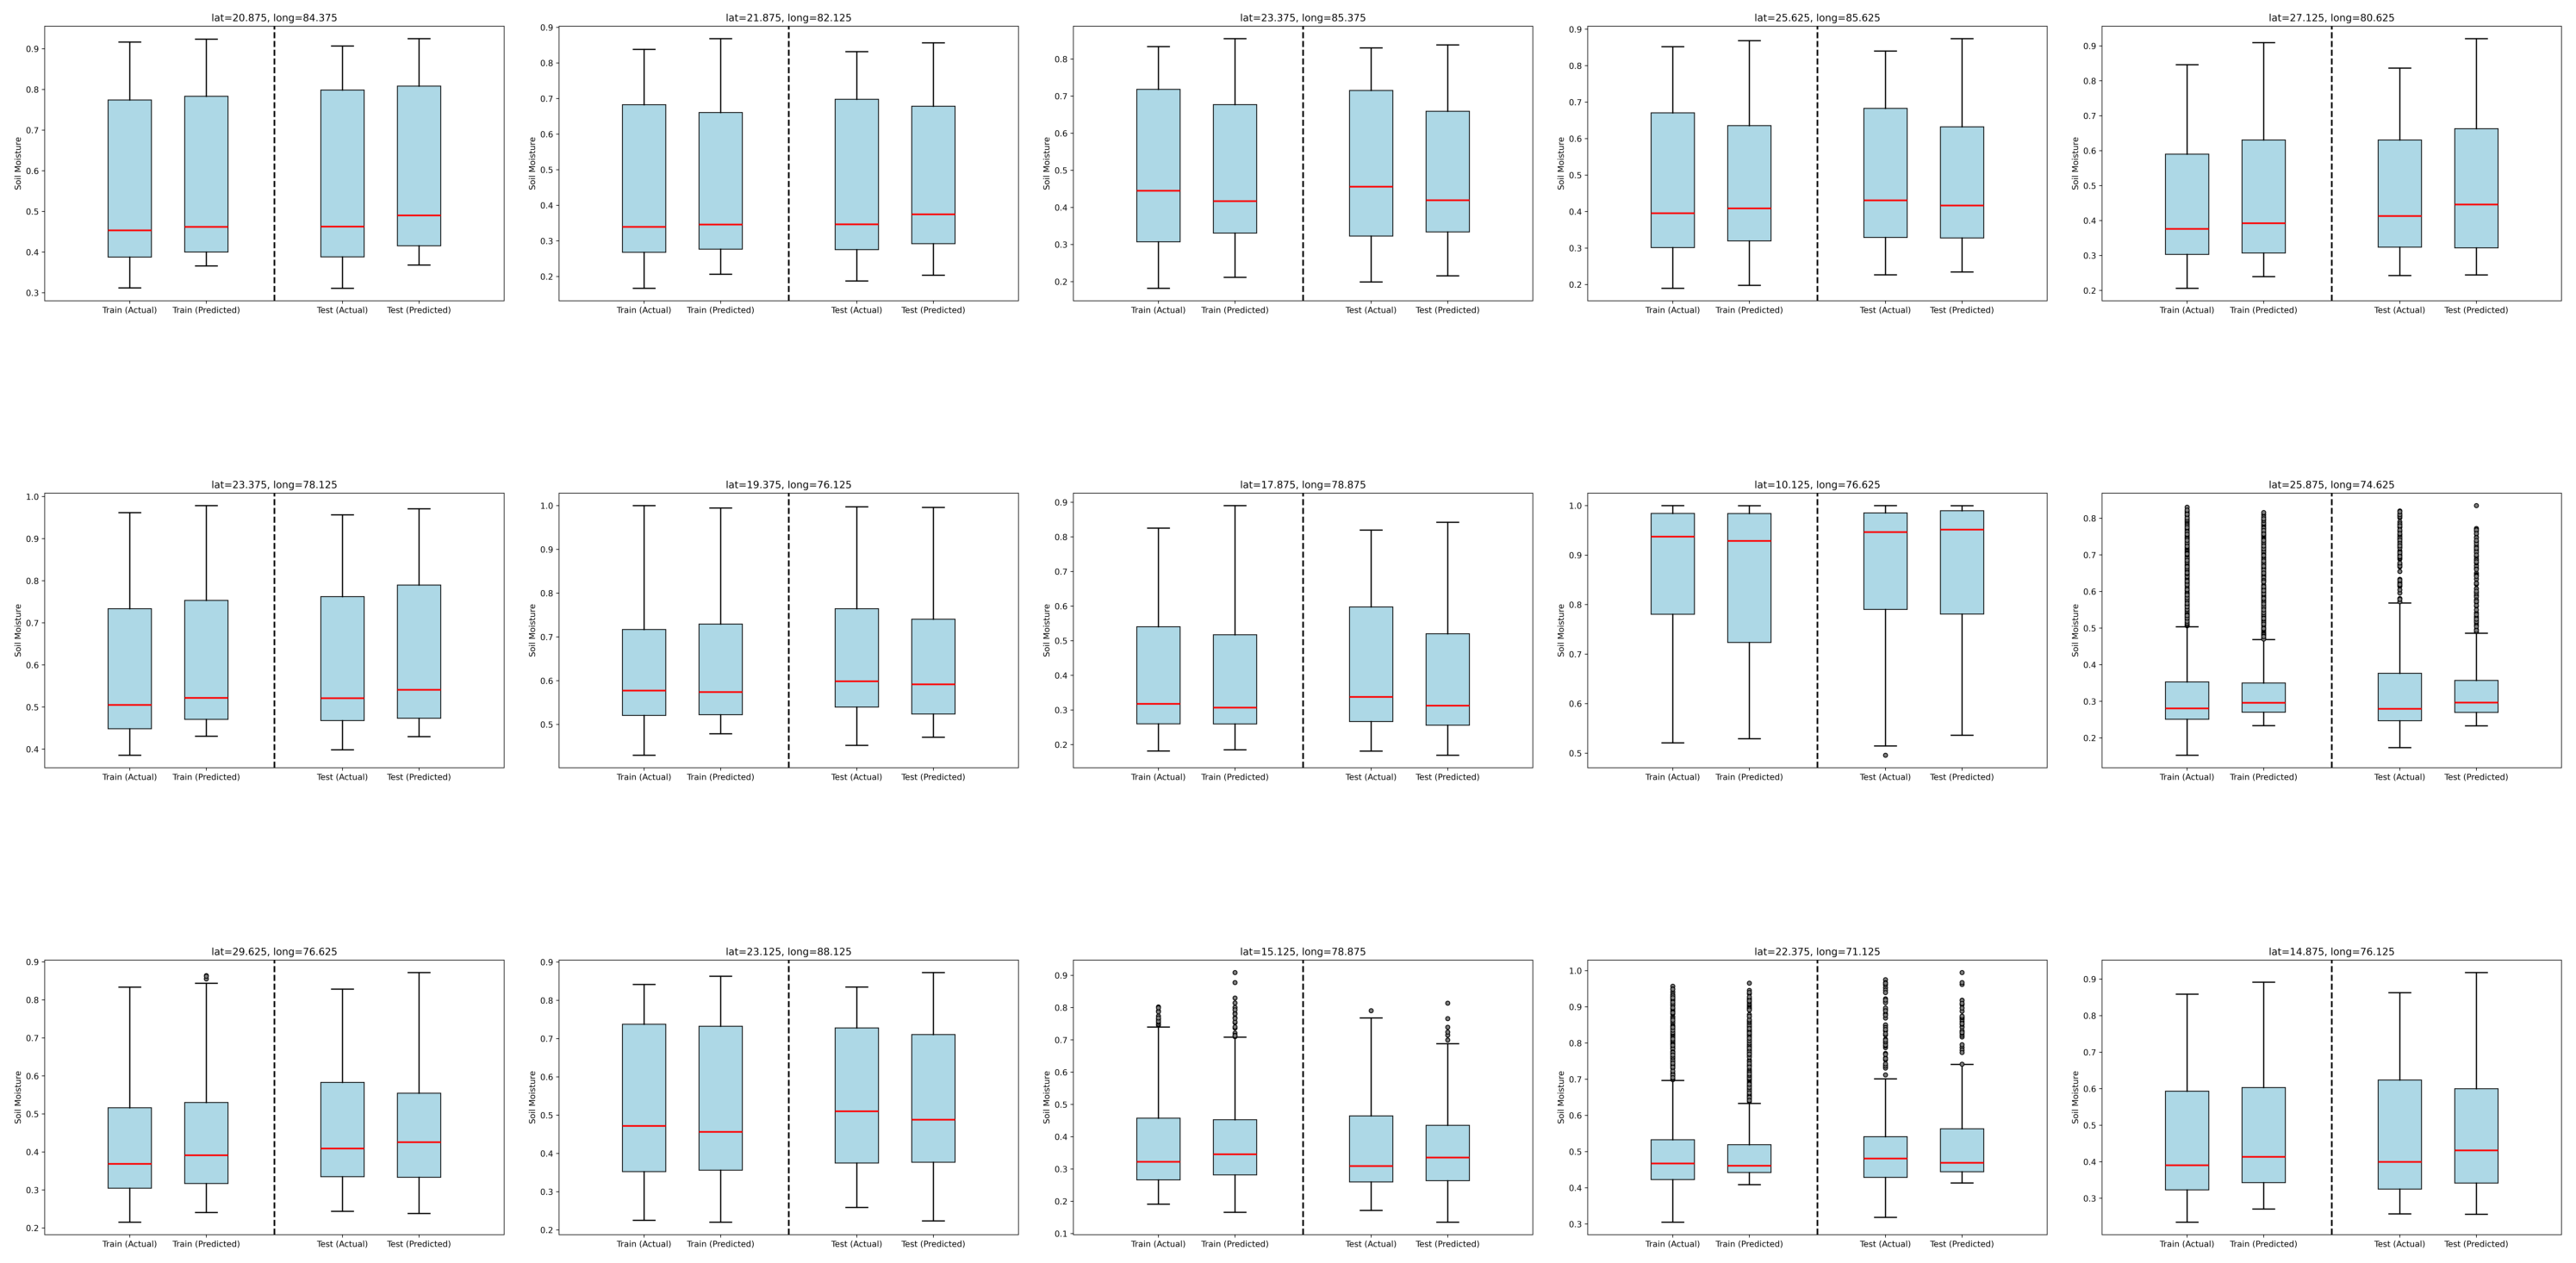

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path where your images are stored (change the directory as needed)
image_dir = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/BoxPlot'

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(3, 5, figsize=(30, 18))
img_no=[3818,3470,3952,3989,3199,2310,1416,2604,1598,842,1676,4204,2593,146,1398]
# Loop through the subplots and load/display the images
for i in range(3):
    for j in range(5):
        # Construct the image filename

        img_path = os.path.join(image_dir, f'{img_no[i*5 + j ]}.png')

        # Read and display the image
        img = mpimg.imread(img_path)

        # Display the image on the corresponding subplot
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Turn off the axis

# Adjust layout to prevent overlap
plt.tight_layout()
path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/BoxPlot/allplot.png'
plt.savefig(path, dpi=600, bbox_inches="tight")
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from PIL import Image
# import os

# # Path where your images are stored (change the directory as needed)
# image_dir = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/BoxPlot'

# # Create a figure with 3 rows and 5 columns with a higher DPI
# fig, axes = plt.subplots(3, 5, figsize=(15, 9), dpi=300)  # Increase DPI for better resolution
# img_no = [3818, 3470, 3952, 3989, 3199, 2310, 1416, 2604, 1598, 842, 1676, 4204, 2593, 146, 1398]

# # Loop through the subplots and load/display the images
# for i in range(3):
#     for j in range(5):
#         # Construct the image filename
#         img_path = os.path.join(image_dir, f'{img_no[i*5 + j]}.png')

#         # Read the image using PIL to get higher quality
#         img = Image.open(img_path)

#         # Display the image on the corresponding subplot with better quality
#         axes[i, j].imshow(img)
#         axes[i, j].axis('off')  # Turn off the axis

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()


 #### ADDITIONAL PLOTS

<ipython-input-113-4f5cbae9bceb>:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True, positions=positions,


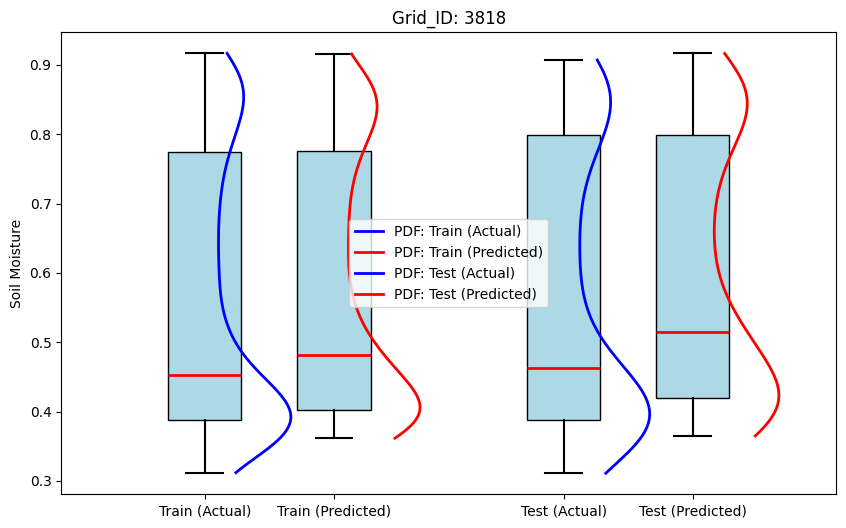

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Convert to 1D (flatten if needed)
Y_train_1d = np.array(Y_train).ravel()
train_pred_1d = np.array(train_pred).ravel()
Y_test_1d = np.array(Y_test).ravel()
test_pred_1d = np.array(test_pred).ravel()

# Combine data for boxplot
data = [Y_train_1d, train_pred_1d, Y_test_1d, test_pred_1d]
labels = ['Train (Actual)', 'Train (Predicted)', 'Test (Actual)', 'Test (Predicted)']

# Define custom positions for spacing
positions = [1, 1.45, 2.25, 2.70]

# Create figure
plt.figure(figsize=(10, 6))

# Create boxplot
plt.boxplot(data, labels=labels, patch_artist=True, positions=positions,
            boxprops=dict(facecolor="lightblue"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black", linewidth=1.5),
            capprops=dict(color="black", linewidth=1.5),
            flierprops=dict(marker="o", markersize=5, markerfacecolor="gray", markeredgecolor="black"))

# Overlay KDE PDFs on top of each boxplot
colors = ['blue', 'red', 'blue', 'red']  # Colors for the PDFs
for i, (dataset, pos, color) in enumerate(zip(data, positions, colors)):
    kde = stats.gaussian_kde(dataset)  # Fit KDE
    x_vals = np.linspace(min(dataset), max(dataset), 100)  # Range of x-values
    y_vals = kde(x_vals)  # Compute KDE values
    y_scaled = y_vals * 0.3 / max(y_vals)  # Normalize and scale for better visibility
    plt.plot(y_scaled + pos, x_vals, color=color, linewidth=2, label=f"PDF: {labels[i]}")  # Shift by position

plt.xticks(positions, labels)  # Ensure correct label alignment
plt.title('Grid_ID: 3818')
plt.ylabel('Soil Moisture')

# Save before showing
# path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Saved/146_Boxplot.png'
plt.savefig(path, dpi=600, bbox_inches="tight")

plt.legend()  # Show legend for PDFs
plt.show()


<ipython-input-121-06087de216d3>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True, positions=positions,


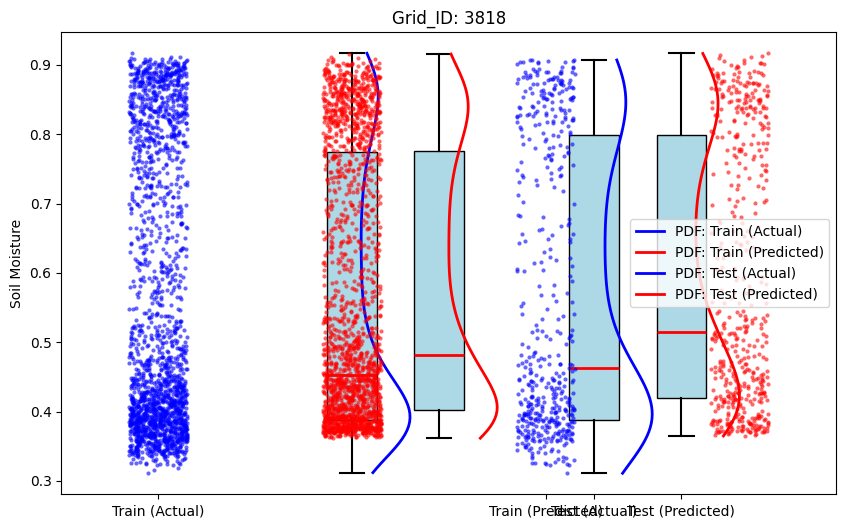

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Convert to 1D (flatten if needed)
Y_train_1d = np.array(Y_train).ravel()
train_pred_1d = np.array(train_pred).ravel()
Y_test_1d = np.array(Y_test).ravel()
test_pred_1d = np.array(test_pred).ravel()

# Combine data for boxplot
data = [Y_train_1d, train_pred_1d, Y_test_1d, test_pred_1d]
labels = ['Train (Actual)', 'Train (Predicted)', 'Test (Actual)', 'Test (Predicted)']

# Define custom positions for spacing
positions = [1, 1.45, 2.25, 2.70]

# Create figure
plt.figure(figsize=(10, 6))

# Create boxplot
plt.boxplot(data, labels=labels, patch_artist=True, positions=positions,
            boxprops=dict(facecolor="lightblue"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black", linewidth=1.5),
            capprops=dict(color="black", linewidth=1.5),
            flierprops=dict(marker="o", markersize=5, markerfacecolor="gray", markeredgecolor="black"))

# Overlay KDE PDFs on top of each boxplot
colors = ['blue', 'red', 'blue', 'red']  # Colors for the PDFs
for i, (dataset, pos, color) in enumerate(zip(data, positions, colors)):
    kde = stats.gaussian_kde(dataset)  # Fit KDE
    x_vals = np.linspace(min(dataset), max(dataset), 100)  # Range of x-values
    y_vals = kde(x_vals)  # Compute KDE values
    y_scaled = y_vals * 0.3 / max(y_vals)  # Normalize and scale for better visibility
    plt.plot(y_scaled + pos, x_vals, color=color, linewidth=2, label=f"PDF: {labels[i]}")  # Shift by position

# Define custom positions for spacing
positions = [0, 2.0, 2.25, 2.70]

# Overlay individual data points using Seaborn stripplot
for i, (dataset, pos, color) in enumerate(zip(data, positions, colors)):
    sns.stripplot(x=np.full_like(dataset, pos), y=dataset, color=color, jitter=0.15, size=3, alpha=0.6)

plt.xticks(positions, labels)  # Ensure correct label alignment
plt.title('Grid_ID: 3818')
plt.ylabel('Soil Moisture')

# Save before showing
# path = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/Plotly/Saved/146_Boxplot.png'
plt.savefig(path, dpi=600, bbox_inches="tight")

plt.legend()  # Show legend for PDFs
plt.show()


# **Model Result Assesment**

..

In [ ]:
rpath='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/ConvLSTMfinal1.csv'
data=pd.read_csv(rpath)
data.head()

,Grid_Id,HPid,Training Time,Train Accuracy,Test Accuracy,Train_MSE,Train_MAE,Train_R,Test MSE,Test MAE,Test R,Train_NSE,Test_NSE
0,16,0,30.292105,79.015415,77.137177,0.001510,0.029159,0.862863,0.001776,0.031247,0.887704,0.810699,0.802114
1,21,0,29.733211,66.832422,66.998012,0.002834,0.036517,0.901133,0.004762,0.046939,0.903599,0.812699,0.801993
2,25,0,31.122287,77.623073,80.516899,0.002937,0.038862,0.899607,0.003363,0.040046,0.910225,0.859230,0.838268
3,26,0,32.312743,79.860766,86.083499,0.002845,0.038021,0.908747,0.004197,0.043174,0.911455,0.839166,0.826183
4,30,0,32.646778,73.545500,80.914513,0.002654,0.033965,0.909397,0.004775,0.045374,0.908081,0.828856,0.809307


In [ ]:
gpath='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/grid.txt'


In [ ]:
import csv

# Define the input and output file paths
txt_file = gpath  # Replace with your txt file path
csv_file = '/content/drive/My Drive/ML_INTERN/AD_PREDICTION/grid.csv'

# Open the txt file and read lines
with open(txt_file, 'r') as txt_f:
    # Open the CSV file for writing
    with open(csv_file, 'w', newline='') as csv_f:
        csv_writer = csv.writer(csv_f)
        # Write the header row
        csv_writer.writerow(['ID', 'LONG', 'LAT'])
        # Read and process each line in the txt file
        for line in txt_f:
            # Split the line by space or comma (change this depending on the txt file format)
            parts = line.strip().split()

            # Ensure the line has 3 parts (ID, LONG, LAT)
            if len(parts) == 3:
                # Write the row to the CSV
                csv_writer.writerow(parts)

print(f"Data has been written to {csv_file}")


Data has been written to /content/drive/My Drive/ML_INTERN/AD_PREDICTION/grid.csv


In [ ]:
odata=pd.read_csv(csv_file)
odata.head()

,ID,LONG,LAT
0,ID,LONG,LAT
1,1,68.375,23.875
2,2,68.625,23.375
3,3,68.625,23.625
4,4,68.625,23.875


In [ ]:
# odata=odata[1:]
odata.head()
odata.to_csv(csv_file,index=False)

In [ ]:
import pandas as pd

# File paths for your input CSV files
csv_file1 = rpath  # Replace with the path to your first CSV file
csv_file2 = csv_file # Replace with the path to your second CSV file

# Read the two CSV files into pandas DataFrames
df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)
df1['Grid_Id'] = df1['Grid_Id']+1
# Merge the two DataFrames on the 'ID' column (you can adjust the column name as needed)
merged_df = pd.merge(df1, df2, left_on='Grid_Id', right_on='ID', how='inner')  # 'how' can be 'left', 'right', 'outer', 'inner'
# Save the merged result to a new CSV file
merged_df.to_csv('merged_output.csv', index=False)

print("Merge complete. Merged file saved as 'merged_output.csv'.")


Merge complete. Merged file saved as 'merged_output.csv'.


In [ ]:
merged_df.head(25)

,Grid_Id,HPid,Training Time,Train Accuracy,Test Accuracy,Train_MSE,Train_MAE,Train_R,Test MSE,Test MAE,Test R,Train_NSE,Test_NSE,ID,LONG,LAT
0,17,0,30.292105,79.015415,77.137177,0.001510,0.029159,0.862863,0.001776,0.031247,0.887704,0.810699,0.802114,17,69.375,21.875
1,22,0,29.733211,66.832422,66.998012,0.002834,0.036517,0.901133,0.004762,0.046939,0.903599,0.812699,0.801993,22,69.375,23.625
2,26,0,31.122287,77.623073,80.516899,0.002937,0.038862,0.899607,0.003363,0.040046,0.910225,0.859230,0.838268,26,69.625,21.875
3,27,0,32.312743,79.860766,86.083499,0.002845,0.038021,0.908747,0.004197,0.043174,0.911455,0.839166,0.826183,27,69.625,22.125
4,31,0,32.646778,73.545500,80.914513,0.002654,0.033965,0.909397,0.004775,0.045374,0.908081,0.828856,0.809307,31,69.625,23.625
5,32,0,34.535820,72.053705,75.944334,0.002413,0.032563,0.907783,0.003889,0.039605,0.911872,0.836378,0.816045,32,69.625,23.875
6,36,0,34.447402,57.086027,52.683897,0.001305,0.027239,0.876616,0.001454,0.029513,0.890682,0.825320,0.802548,36,69.875,21.375
7,37,0,31.457193,85.479861,87.673956,0.002601,0.037027,0.909049,0.002553,0.035216,0.927254,0.885936,0.861944,37,69.875,21.625
8,38,0,30.354478,100.000000,100.000000,0.003144,0.042735,0.908140,0.003952,0.045838,0.907720,0.836140,0.823626,38,69.875,21.875
9,39,0,30.158964,89.955246,94.632207,0.003189,0.042120,0.907222,0.005332,0.052723,0.887723,0.824897,0.801345,39,69.875,22.125


In [ ]:
merged_df.shape

(3694, 16)

In [ ]:
fpath='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/finalConvLSTM_LL.csv'
merged_df.to_csv(fpath,index=False)

In [ ]:
work=merged_df[['Grid_Id','LONG','LAT']]
work.head(5)

,Grid_Id,LONG,LAT
0,17,69.375,21.875
1,22,69.375,23.625
2,26,69.625,21.875
3,27,69.625,22.125
4,31,69.625,23.625


In [ ]:
dpath='/content/drive/My Drive/ML_INTERN/AD_PREDICTION/finalConvLSTM_LLonly.csv'
work.to_csv(dpath,index=False)